# Barrier Options - Reiner & Rubinstein (1991)

> Author: Gustavo Monteiro de Athayde  
> Monitor: Sylvio Ximenez de Azevedo Neto - <<sylvioxan@insper.edu.br>>  
> Date: 05/04/2025

In [1]:
from lib import derivatives as dg
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np

### Call Down & In barrier

In [2]:
# strike price
K = 100
H = 80

# stock price at expiration
prices = np.linspace(0, 200, 1000)

# payoff of the option at expiration
payoff = np.maximum(prices - K, 0)

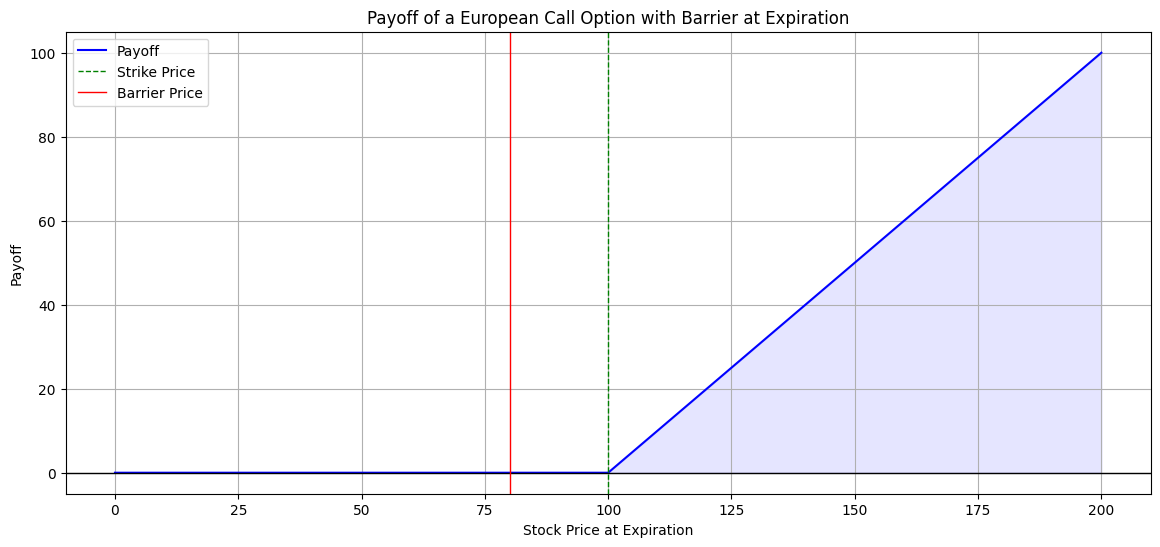

In [3]:
# plot payoff 
plt.figure(figsize=(14, 6))
plt.plot(prices, payoff, label='Payoff', color='blue')
plt.axhline(0, color='black', lw=1)
plt.axvline(K, color='green', lw=1, label='Strike Price', linestyle='--')
plt.axvline(H, color='red', lw=1, label='Barrier Price')
plt.title('Payoff of a European Call Option with Barrier at Expiration')
plt.fill_between(prices, 0, payoff, where=(prices > K), color='blue', alpha=0.1)
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Payoff')
plt.legend()
plt.grid()
plt.show()

### Désiré André - Reflection Principle

Image definition:

$$ \ln(I) = \ln(H) - [\ln(S_0) - \ln(H)] = \ln \Biggl(\frac{H^2}{S_0} \Biggl) $$

But for the implementation, we need to use the following:

$$ \ln(I) = \ln(H) - [\ln(S_0) - \ln(H)] = 2\ln(H) - \ln(S_0) $$

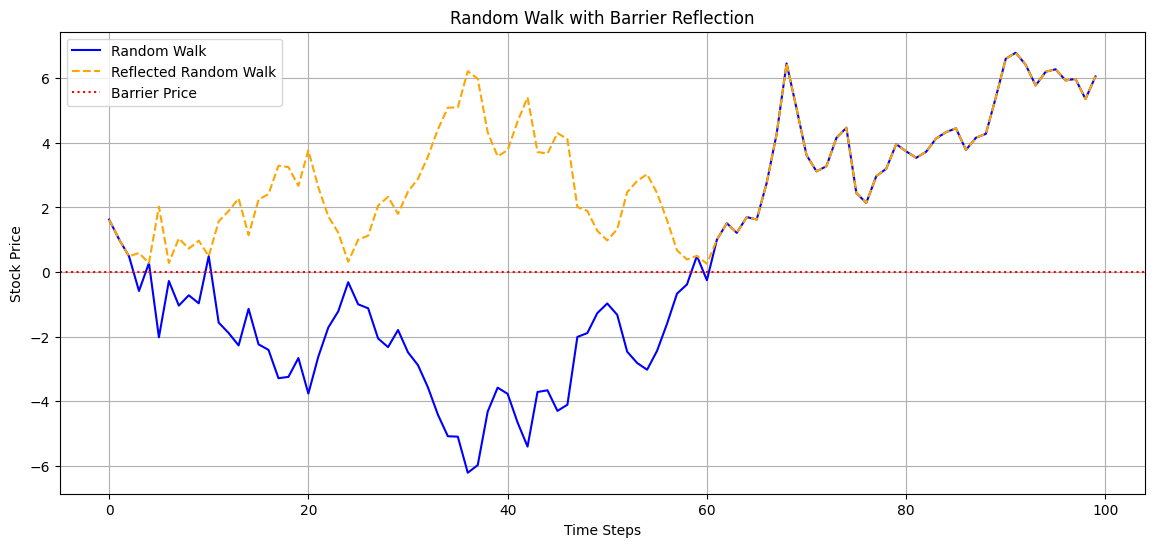

In [4]:
# Generating the ramdon walk data
# np.random.seed(42)
np.random.seed(1)
n_steps = 100
steps = np.random.normal(loc=0, scale=1, size=n_steps)
log_prices = np.cumsum(steps)

# Apply reflection principle to the random walk
boundary = 0
reflected_prices = np.where(log_prices < boundary, 2 * boundary - log_prices, log_prices)

# Plot the random walk and the barrier
plt.figure(figsize=(14, 6))
plt.plot(log_prices, label='Random Walk', color='blue')
plt.plot(reflected_prices, label='Reflected Random Walk', color='orange', linestyle='--')
plt.axhline(boundary, color='red', label='Barrier Price', linestyle=':')
plt.title('Random Walk with Barrier Reflection')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()





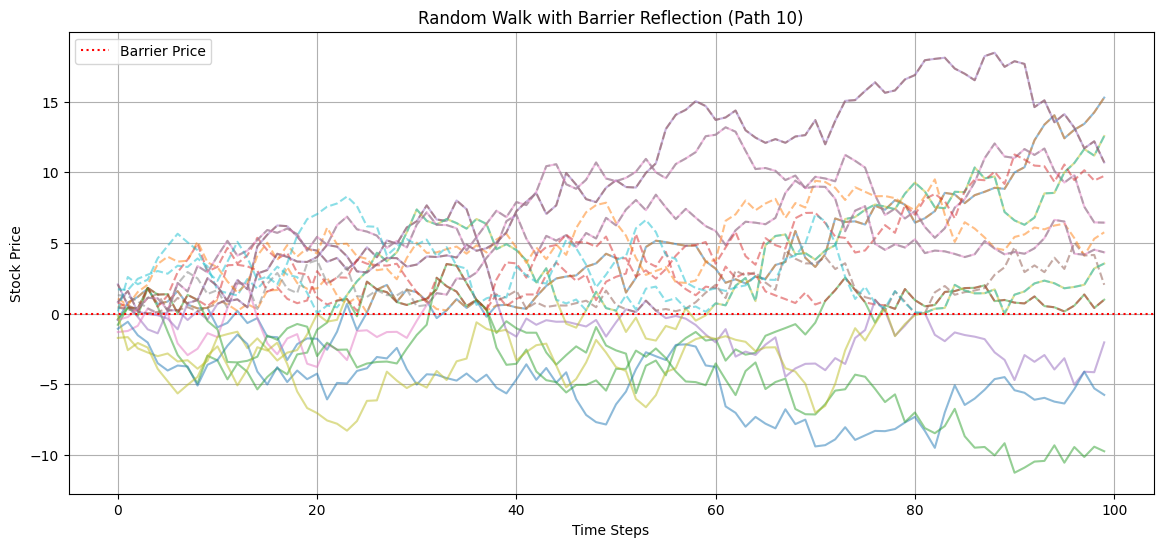

In [5]:
# function to generate random walk and apply reflection principle
def generate_random_walk(n_steps, boundary):
    steps = np.random.normal(loc=0, scale=1, size=n_steps)
    log_prices = np.cumsum(steps)
    reflected_prices = np.where(log_prices < boundary, 2 * boundary - log_prices, log_prices)
    return log_prices, reflected_prices


# parameters
n_paths = 10
n_steps = 100
boundary = 0

# plot paths
plt.figure(figsize=(14, 6))

for i in range(n_paths):
    log_prices, reflected_prices = generate_random_walk(n_steps, boundary)
    plt.plot(log_prices, alpha=0.5)
    plt.plot(reflected_prices, linestyle='--', alpha=0.5)
    

plt.title(f'Random Walk with Barrier Reflection (Path {i+1})')
plt.axhline(boundary, color='red', label='Barrier Price', linestyle=':')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

### Barrier Options - Pricing implementation

### Call Donw (H<X)

![images/call_down_K_H.png](images/call_down_k_h.png)

In [6]:
def barrier_call_option_down_in_h_x(S0, K, H, T, r, sigma, mu):
    """
    Calculate the price of a down-and-in barrier call option with drift.
    
    Parameters:
    S0 : float : initial stock price
    K : float : strike price
    H : float : barrier price
    T : float : time to expiration in years
    r : float : risk-free interest rate
    sigma : float : volatility of the stock
    mu : float : drift of the stock price
    
    """
    return (H/S0)**(2*mu/sigma**2) * dg.bs_call_option((H**2/S0), K, T, r, sigma)


def barrier_call_option_down_out_h_x(S0, K, H, T, r, sigma, mu):
    """
    Calculate the price of a down-and-out barrier call option with drift.
    
    Parameters:
    S0 : float : initial stock price
    K : float : strike price
    H : float : barrier price
    T : float : time to expiration in years
    r : float : risk-free interest rate
    sigma : float : volatility of the stock
    mu : float : drift of the stock price
    
    """
    return dg.bs_call_option(S0, K, T, r, sigma) - barrier_call_option_down_in_h_x(S0, K, H, T, r, sigma, mu)

In [7]:
# example usage
S0 = 90  # initial stock price
K = 120   # strike price
H = 100    # barrier price
T = 1     # time to expiration in years
r = 0.05  # risk-free interest rate
sigma = 0.2  # volatility of the stock
mu = 0.1  # drift of the stock price

price_cdi = barrier_call_option_down_in_h_x(S0, K, H, T, r, sigma, mu)

# S0 = 110
price_cdo = barrier_call_option_down_out_h_x(S0, K, H, T, r, sigma, mu)

print(f"Down-and-in barrier call option price: {price_cdi:.2f}")
print(f"Down-and-out barrier call option price: {price_cdo:.2f}")

Down-and-in barrier call option price: 12.76
Down-and-out barrier call option price: -11.60


### Call Down (H > X)

![images/call_down_h_k.png](images/call_down_h_k.png)

In [8]:
def barrier_call_option_down_in_x_h(S0, K, H, T, r, sigma, mu):
    """
    Calculate the price of an up-and-in barrier call option with drift.
    
    Parameters:
    S0 : float : initial stock price
    K : float : strike price
    H : float : barrier price
    T : float : time to expiration in years
    r : float : risk-free interest rate
    sigma : float : volatility of the stock
    mu : float : drift of the stock price
    
    """
    return dg.bs_call_option(S0, H, T, r, sigma) + (H - K) * dg.binary(S0, H, dg.OptionType.CALL) - (H/S0)**(2*mu/sigma**2) * ( dg.bs_call_option((H**2/S0), H, T, r, sigma) - (H - K) * dg.binary(H**2/S0, H, dg.OptionType.CALL))

In [9]:
def barrier_call_option_down_out_x_h(S0, K, H, T, r, sigma, mu):
    """
    Calculate the price of an up-and-out barrier call option with drift.
    
    Parameters:
    S0 : float : initial stock price
    K : float : strike price
    H : float : barrier price
    T : float : time to expiration in years
    r : float : risk-free interest rate
    sigma : float : volatility of the stock
    mu : float : drift of the stock price
    
    """
    return dg.bs_call_option(S0, K, T, r, sigma) - barrier_call_option_down_in_x_h(S0, K, H, T, r, sigma, mu)

In [10]:
# usage example
S0 = 150  # initial stock price
K = 120   # strike price
H = 140    # barrier price
T = 1     # time to expiration in years
r = 0.05  # risk-free interest rate
sigma = 0.2  # volatility of the stock
mu = 0.1  # drift of the stock price

price_cdi = barrier_call_option_down_in_x_h(S0, K, H, T, r, sigma, mu)
price_cdo = barrier_call_option_down_out_x_h(S0, K, H, T, r, sigma, mu)

print(f'Down-and-in barrier call option price (H>K): {price_cdi:.2f}')
print(f'Down-and-out barrier call option price (H>K): {price_cdo:.2f}')

Down-and-in barrier call option price (H>K): 15.03
Down-and-out barrier call option price (H>K): 21.85


### Call UP (H > X)

![images/call_up.png](images/call_up.png)

In [14]:
def barrier_call_option_up_out_h_x(S0, K, H, T, r, sigma, mu):
    """
    Calculate the price of an up-and-in barrier call option with drift.
    
    Parameters:
    S0 : float : initial stock price
    K : float : strike price
    H : float : barrier price
    T : float : time to expiration in years
    r : float : risk-free interest rate
    sigma : float : volatility of the stock
    mu : float : drift of the stock price
    
    """
    return dg.bs_call_option(S0, K, T, r, sigma) - dg.bs_call_option(S0, H, T, r, sigma) - (H - K) * dg.binary(S0, H, dg.OptionType.CALL) + (H/S0)**(2*mu/sigma**2) * ( dg.bs_call_option((H**2/S0), K, T, r, sigma) - dg.bs_call_option((H**2/S0), H, T, r, sigma) - (H - K) * dg.binary(H**2/S0, H, dg.OptionType.CALL))

In [15]:
def barrier_call_option_up_in_h_x(S0, K, H, T, r, sigma, mu):
    """
    Calculate the price of an up-and-out barrier call option with drift.
    
    Parameters:
    S0 : float : initial stock price
    K : float : strike price
    H : float : barrier price
    T : float : time to expiration in years
    r : float : risk-free interest rate
    sigma : float : volatility of the stock
    mu : float : drift of the stock price
    
    """
    return dg.bs_call_option(S0, K, T, r, sigma) - barrier_call_option_up_out_h_x(S0, K, H, T, r, sigma, mu)

In [16]:
# usage example
S0 = 150  # initial stock price
K = 120   # strike price
H = 140    # barrier price
T = 1     # time to expiration in years
r = 0.05  # risk-free interest rate
sigma = 0.2  # volatility of the stock
mu = 0.1  # drift of the stock price

price_cdi = barrier_call_option_up_in_h_x(S0, K, H, T, r, sigma, mu)
price_cdo = barrier_call_option_up_out_h_x(S0, K, H, T, r, sigma, mu)

print(f'Up-and-in barrier call option price (H<K): {price_cdi:.2f}')
print(f'Up-and-out barrier call option price (H<K): {price_cdo:.2f}')

Up-and-in barrier call option price (H<K): 13.94
Up-and-out barrier call option price (H<K): 22.94


### Rebates at expiration



In [47]:
def rebate(R, S, K, H, T, mu, sigma):
    """
    Calculate the rebate for a down-and-in call option.
    
    Parameters:
    R (float): Rebate amount
    S (float): Current stock price
    K (float): Strike price
    H (float): Barrier level
    T (float): Time to expiration
    mu (float): Drift of the underlying asset
    sigma (float): Volatility of the underlying asset
    
    Returns:
    float: Rebate value
    """
    
    # Calculate the rebate value based on the parameters
    if S > H:        
        rebate_value = R * (dg.binary(S, H, dg.OptionType.CALL) + (H/S)**(2*mu/sigma**2) * dg.binary((H**2/S), H, dg.OptionType.PUT ))
    else:
        rebate_value = R * (dg.binary(S, H, dg.OptionType.PUT) + (H/S)**(2*mu/sigma**2) * dg.binary((H**2/S), H, dg.OptionType.CALL ))
    
    return rebate_value

In [56]:
# usage example
S = 10  # current stock price
K = 100   # strike price
H = 120    # barrier price
T = 1     # time to expiration in years
R = 100    # rebate amount
mu = 0.1  # drift of the stock price
sigma = 0.2  # volatility of the stock

rebate_value = rebate(R, S, K, H, T, mu, sigma)
print(f'Rebate value: {rebate_value}')


Rebate value: 24.883097108283835
